<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/GetMasksOfTrackedCellsOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Load required libraries 

In [3]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import ntpath
import os
import pickle
import re
import copy
import scipy
from scipy import ndimage

In [4]:
#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries /content

from libraries.filter_cells_fns import *
from libraries.centers import get_centers

### Input required to copy data from bucket to colab (tracks, images and masks)

In [5]:
#@markdown output_path is the path to folder_output (where tracks must be stored) in GCP bucket
output_path = 'cellmbucket/analysis_eliz_05042021/trial5' #@param {type:"string"}
#@markdown experiment is the name of the experiment analzyed (this was defined in the tracking section and makes part of the name of the tracks file)
experiment='060622021_ARPC2_KO_sample4'  #@param {type:"string"}



##Get masks of tracked cells only for all tracked cells present in each frame

In [6]:
#Get labeled masks and tracks from GCP bucket

!gsutil cp gs://{output_path}/{experiment}_labeledmasks.zip /content
!gsutil cp gs://{output_path}/{experiment}_tracks_shape.pkl /content

!unzip {experiment}_labeledmasks.zip

masks_folder = experiment+'_labeledmasks'
trackedmasks_folder = experiment+'_trackedmasks'

!mkdir {trackedmasks_folder}

with open(experiment+'_tracks_shape.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')

Streaming output truncated to the last 5000 lines.
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s17_t65.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s5_t102.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s21_t53.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s18_t63.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s29_t122.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s22_t163.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s32_t114.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s14_t152.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s24_t62.TIF  
  inflating: 060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s28_t172.TIF  
  inflating: 060622021_ARPC2_KO_sa

In [7]:
#Recombine dataframes of saved tracks. Original format is a list of dataframes where each dataframe
#is a separate track and it contains the track movie, frame number, and label number used
#in labeledmasks.zip and restructures it so that we are left with a list of dataframes where each
#dataframe contains all the tracks present in each frame for each movie

#This is accomplished by appending the dataframe of one track to the list singletr_movie and comparing the movie number (track_init) of each dataframe in "tracks" with the movie number of the next dataframe (track_next)
#If track_init == track_next we append the dataframe corresponding to track_next to the list multitr_movie (this means there are multiple tracks for this movie)
#Otherwise we appned the first dataframe in singletr_movie to multitr_movie and append multitr_movie to tracks_by_movie, the final list of dataframes we want
#We append the first dataframe of singletr_movie to avoid repeats since if track_init==track_next for a movie there will be the same dataframe in both lists

#where final list of dataframes will be stored (where each dataframe contains all tracks present in each frame for each movie)
tracks_by_movie = []
#list where will temporarily store dataframes while going through tracks
singletr_movie = []
#list where we will temporarily store dataframes if there are multiple tracks for each movie 
multitr_movie = []
for i in range(len(tracks)-1):
  track_init = int(tracks[i]['movie'].unique())
  singletr_movie.append(tracks[i])
  track_next = int(tracks[i+1]['movie'].unique())
  if track_init == track_next:
    multitr_movie.append(tracks[i+1])
  else:
    multitr_movie.append(singletr_movie[0])
    tracks_by_movie.append(multitr_movie)
    singletr_movie = []
    multitr_movie = []

#The structure of tracks_by_movie  is now a list of dataframes where each element of this list reperesents each movie, however if there is more than one track for a movie there are 2 or more separate dataframes for that movie that
#correspond to each track. We want to concatenate these dataframes so that we have one dataframe for each movie that contains all the tracks for that movie
for i in range(len(tracks_by_movie)):
  tracks_by_movie[i] = pd.concat(tracks_by_movie[i], ignore_index=True)

In [8]:
print(tracks_by_movie[1]['frame'].unique())

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.]


In [11]:
#function that returns the mask of a cell. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later).
def get_cell(iframe):
  mask=get_mask(iframe)
  #get all labels for all tracked cells for each frame
  labels_for_frame = tracks_by_movie[itrack].loc[tracks_by_movie[itrack]['frame'] == iframe, 'label'].array  
  #erase all objects with different label as tracked cells
  mask[np.isin(mask, labels_for_frame, invert=True) ] =0

  return mask

In [12]:
#function to read a mask corresponding to a given movie (implicit parameter), and frame (explicit parameter iframe)
get_mask = lambda iframe: imread( masks_folder +'/'+ basename+ '_s' + str(int(movie)) +'_t' + str(int(iframe)) + '.TIF')

#Here we make a copy of tracks_by_movie and name it tracks 
#We loop through each element (where each element is a dataframe that has labels for all the tracks for each movie) and go through each frame movie and save images of masks for all cells that are tracked in each frame
tracks = copy.copy(tracks_by_movie)

for itrack in range(len(tracks)):
  movie = tracks[itrack]['movie'].iloc[0]
  frame = tracks[itrack]['frame'].unique()
  masks=os.listdir(masks_folder)
  #implicit argument to read cells
  basename=re.findall(r"(.+)_s",masks[0])[0] 
  for iframe in frame:
    #get scikit defined cell metrics
    cell = get_cell(iframe)
    imsave(trackedmasks_folder + '/' + basename + "_s" + str(int(movie))+'_t'+str(int(iframe))+'.TIF' , cell)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s1_t1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s1_t2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s1_t3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s1_t4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s1_t5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: 060622021_ARPC2_KO_sample4_trackedmasks/06

In [ ]:
#zip masks of tracked cells
!zip -r {trackedmasks_folder}.zip {trackedmasks_folder}

#transfer data to GCP bucket
!gsutil cp {trackedmasks_folder}.zip gs://{output_path}

  adding: 060622021_ARPC2_KO_sample4_trackedmasks/ (stored 0%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s1_t31.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s9_t94.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s12_t107.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s12_t161.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s18_t106.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s7_t174.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s23_t24.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s13_t125.TIF (deflated 100%)
  adding: 060622021_ARPC2_KO_sample4_trackedmasks/060622021_Sample4_w1DIC_s13_t129.TIF (deflated 100%)
  adding: 060622

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


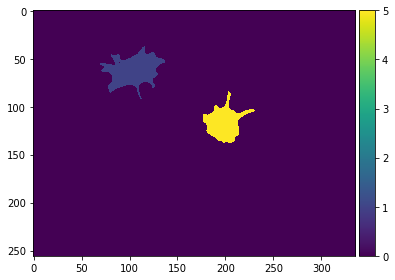

In [13]:
imshow(trackedmasks_folder + '/060622021_Sample4_w1DIC_s2_t1.TIF')

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


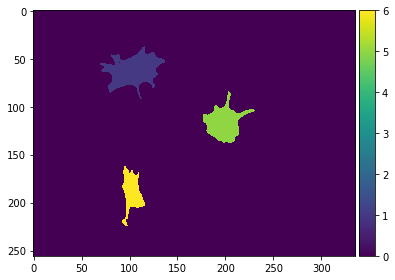

In [14]:
imshow('/content/060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s2_t1.TIF')

In [15]:
print(imread('/content/060622021_ARPC2_KO_sample4_labeledmasks/060622021_Sample4_w1DIC_s2_t1.TIF'))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
